# Wasserstein Generative Adversarial Network (WGAN)

In this notebook we follow the Wasserstein Generative Adversarial Network (WGAN) algorithm introduced in *Wasserstein GAN* by Arjovsky et al.

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
plt.rcParams['figure.figsize'] = 7, 5

In [2]:
cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))

Training on CPU


## 1. Discriminator Vanishing Gradient

Following the paper, let's train the GAN discriminator to convergence as well as the WGAN and compare their gradients.

In [3]:
discriminator_GAN =  nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid())
optimizer = torch.optim.RMSprop(params=discriminator_GAN.parameters(), lr=.01)

In [4]:
batch = 64
iters = 100
mean = 5
for i in range(iters + 1):
    X_true = torch.randn(batch) - mean
    X_false = torch.randn(batch) + mean
    X = Variable(torch.cat([X_true, X_false])).unsqueeze(1)
    y = Variable(torch.cat([torch.ones(batch), torch.zeros(batch)]))
    output = discriminator_GAN(X)
    loss = nn.BCELoss()(output, y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print('[%i/%i] Loss %.2f' % (i, iters, loss.data[0]))

[0/100] Loss 0.70
[10/100] Loss 0.00
[20/100] Loss -0.00
[30/100] Loss -0.00
[40/100] Loss -0.00
[50/100] Loss -0.00
[60/100] Loss -0.00
[70/100] Loss -0.00
[80/100] Loss -0.00
[90/100] Loss -0.00
[100/100] Loss -0.00


In [48]:
discriminator_WGAN =  nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1))
optimizer = torch.optim.RMSprop(params=discriminator_WGAN.parameters(), lr=.001)

In [49]:
c = .1
for i in range(iters + 1):
    X_true = Variable(torch.randn(batch) - mean)
    X_fake = Variable(torch.randn(batch) + mean)
    output_true = discriminator_WGAN(X_true.unsqueeze(1))
    output_fake = discriminator_WGAN(X_fake.unsqueeze(1))
    loss = torch.mean(output_true) - torch.mean(output_fake)
    loss.backward()
    optimizer.step()
    for p in discriminator_WGAN.parameters():
        p.data.clamp_(-c, c) # enforce a Lipschitz constraint
    if i % 10 == 0:
        print('[%i/%i] Loss %.2f' % (i, iters, loss.data[0]))

[0/100] Loss -0.57
[10/100] Loss -0.18
[20/100] Loss -0.27
[30/100] Loss -0.34
[40/100] Loss -0.38
[50/100] Loss -0.42
[60/100] Loss -0.43
[70/100] Loss -0.44
[80/100] Loss -0.44
[90/100] Loss -0.43
[100/100] Loss -0.45


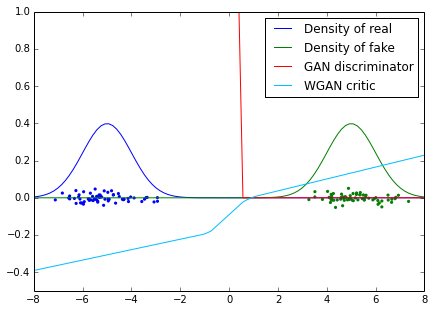

In [51]:
x = Variable(torch.linspace(-8, 8, 100)).unsqueeze(1)
y1 = discriminator_GAN(x).data.cpu().numpy()
y2 = discriminator_WGAN(x).data.cpu().numpy()
x = x.data.cpu().numpy()
plt.scatter(X_true.data.cpu().numpy(), np.random.randn(batch) * 0.02, c='blue', s=10, lw=0)
plt.scatter(X_fake.data.cpu().numpy(), np.random.randn(batch) * 0.02, c='green', s=10, lw=0)
plt.plot(x, norm.pdf(x, loc=-mean), c='blue', label='Density of real')
plt.plot(x, norm.pdf(x, loc=mean), c='green', label='Density of fake')
plt.plot(x, y1, c='red', label='GAN discriminator')
plt.plot(x, y2, c='deepskyblue', label='WGAN critic')
plt.ylim(-.5, 1)
plt.xlim(-8, 8)
plt.legend();

Above we reproduce the figure 2 of the paper. We notice the vanishing gradient of the GAN discriminator that cannot give a meaningful signal to train the generator. On the other hand, we remark a piecewise linear WGAN critic that has a *strong* gradient signal everywhere.

## 2. Training WGAN

In [3]:
batch = 64
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])
mnist = torchvision.datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=batch, shuffle=True, drop_last=True)

In [4]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), # input (1, 28, 28), output (32, 28, 28)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # (32, 14, 14)
            nn.Conv2d(32, 64, 3), # (64, 12, 12)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)) # (64, 6, 6)
        self.fc = nn.Sequential(
            nn.Linear(64 * 6 * 6, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 1))
    
    def forward(self, x):
        x  = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)
    
critic = Critic().type(FloatTensor)

In [5]:
lr = 0.001
opt_c = torch.optim.RMSprop(params=critic.parameters(), lr=lr)

In [6]:
batch = 64
epochs = 10
c = .1
for i in range(epochs):
    for j, (images, _) in enumerate(data_loader):
        critic.zero_grad()
        X_true = Variable(images).type(FloatTensor)
        X_fake = Variable(torch.randn(X_true.size())).type(FloatTensor)
        output_true = critic(X_true)
        output_fake = critic(X_fake)

        loss_t = torch.mean(output_true)
        loss_f =  torch.mean(output_fake)
        loss = loss_t - loss_f
        loss.backward()
        opt_c.step()
        for p in critic.parameters():
            p.data.clamp_(-c, c) # enforce Lipschitz constraint
            
        if j % 100 == 0:
            print('[%i/%i] [%i/%i] Loss %.5f loss_t %.5f loss_f %.5f' %
                  (i, epochs, j, int(60000. / batch), loss.data[0], loss_t.data[0], loss_f.data[0]))

[0/10] [0/937] Loss 0.00000 loss_t -0.00803 loss_f -0.00803
[0/10] [100/937] Loss 0.00000 loss_t -0.00803 loss_f -0.00803
[0/10] [200/937] Loss -0.00000 loss_t -0.00803 loss_f -0.00803
[0/10] [300/937] Loss -0.00000 loss_t -0.00803 loss_f -0.00803


KeyboardInterrupt: 